I have used Keras which is a high-level API of TensorFlow 2.0 and Python 3.6.9. I have referred online resources for this task (especially the use of attention layer). I am using a subset of dataset with only 25000 samples and trained on Google Collab. (To Do: Metrics to analyse the results)

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from platform import python_version

print('Python Version:', python_version())
#Read the file - Using only a subset of the original dataset
#reviews_data.loc[1:1000000].to_csv('updated_reviews_file_1L.csv')
reviews_data = pd.read_csv('updated_reviews_file_25k.csv')
reviews_data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Python Version: 3.6.9


,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
2,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...


In [2]:
#Check for null values. 
reviews_data.isnull().sum()

Unnamed: 0                0
Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [3]:
#Keep only input and labels. Drop the rest of the columns.
reviews_data = reviews_data.dropna()
reviews_data = reviews_data.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'], 1)
reviews_data = reviews_data.reset_index(drop=True)
reviews_data.head()

,Unnamed: 0,Summary,Text
0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,2,"""Delight"" says it all",This is a confection that has been around a fe...
2,3,Cough Medicine,If you are looking for the secret ingredient i...
3,4,Great taffy,Great taffy at a great price. There was a wid...
4,5,Nice Taffy,I got a wild hair for taffy and ordered this f...


In [4]:
reviews_data.count()

Unnamed: 0    25000
Summary       25000
Text          25000
dtype: int64

In [5]:
#Print some of the text and summaries.
for print_data_id in range(10):
    print("Text and Summary No.",print_data_id+1)
    print('Summary :',reviews_data.Summary[print_data_id])
    print('Text :',reviews_data.Text[print_data_id])
    print()

Text and Summary No. 1
Summary : Not as Advertised
Text : Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Text and Summary No. 2
Summary : "Delight" says it all
Text : This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.

Text and Summary No. 3
Summary : Cough Medicine
Text : If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root 

NLP Pipeline:
1. Data Preparation & Visualization
2. Data Pre-processing (Contractions, Convert to lower case, Remove punctuations, urls, special characters, stopwords etc.)
3. Split the dataset for training and testing. - Using only a subset of the original reviews.csv dataset 
4. Word embeddings using Glove (Stanford's GloVe 100d word embeddings: glove.6B.100d.txt).
5. Process of Tokenization.
6. Model Creation (LSTM and Attention).
7. Model Training.
8. Model Inference.
9. Visualize the Results (Prediction Summaries & Attention Plots).

In [6]:
contractions_list = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"here's": "here is", 
"hasn't": "has not", 
"how'd'y": "how do you", 
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"I'd've": "I would have",  
"I'll've": "I will have",
"i'd've": "i would have",   
"i'll've": "i will have", 
"it'd've": "it would have",  
"it'll've": "it will have", 
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"mightn't've": "might not have",  
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"oughtn't": "ought not",
"o'clock": "of the clock",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shan't've": "shall not have",
"she'd've": "she would have", 
"she'll've": "she will have", 
"shouldn't've": "should not have", 
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"this's": "this is", 
"that'd've": "that would have", 
"there'd": "there would",
"there'd've": "there would have",  
"they'd've": "they would have",
"they'll've": "they will have",  
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"we'd've": "we would have", 
"we'll've": "we will have", 
"what'll've": "what will have", 
"when's": "when is", 
"when've": "when have", 
"where've": "where have", 
"who'll've": "who will have", 
"who've": "who have",
"why's": "why is", 
"why've": "why have", 
"will've": "will have",  
"won't've": "will not have",
"would've": "would have", 
"wouldn't've": "would not have",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd've": "you would have", 
"you'll've": "you will have",
"you've": "you have"
}

In [7]:
#print(punctuation)
#Data Preprocessing.
def preprocess_text_summary(text_summary, eliminate_stopwords = True):
    #Remove punctuations, text within parentheses, special characters, br tags, urls, and convert to lower case.
    text_summary = text_summary.lower() 
    text_summary = ''.join([punc for punc in text_summary if punc not in punctuation])
    text_summary = re.sub(r'/^https?:\/\//', '', text_summary)
    text_summary = re.sub(r'&amp;', '', text_summary)
    text_summary = re.sub(r'\([^)]*\)', '', text_summary) 
    text_summary = re.sub('"','', text_summary)
    text_summary = re.sub(r'<br />', ' ', text_summary)
    text_summary = re.sub(r'[^a-zA-Z0-9. ]','',text_summary)

    #Replace contractions from their shorter forms.
    if True:
        text_summary = text_summary.split()
        long_text_summary = []
        for contraction in text_summary:
            if contraction in contractions_list:
                long_text_summary.append(contractions_list[contraction])
            else:
                long_text_summary.append(contraction)
        text_summary = " ".join(long_text_summary)
    
    #Eliminate stopwords.
    if eliminate_stopwords:
        stopword_list = set(stopwords.words("english"))
        text_summary = " ".join([sw for sw in text_summary.split() if not sw in stopword_list])

    return text_summary

In [8]:
preprocessed_summaries = []
for summary in reviews_data["Summary"]:
    preprocessed_summaries.append(preprocess_text_summary(summary, eliminate_stopwords = False))
print("Summaries Preprocessed.")

preprocessed_texts = []
for text in reviews_data["Text"]:
    preprocessed_texts.append(preprocess_text_summary(text))
print("Texts Preprocessed.")


Summaries Preprocessed.
Texts Preprocessed.


In [9]:
#Review pre-processed texts and summaries.
for print_data_id in range(10):
    print("Text and Summary No.",print_data_id+1)
    print('Summary :',preprocessed_summaries[print_data_id])
    print('Text :',preprocessed_texts[print_data_id])
    print()

Text and Summary No. 1
Summary : not as advertised
Text : product arrived labeled jumbo salted peanutsthe peanuts actually small sized unsalted sure error vendor intended represent product jumbo

Text and Summary No. 2
Summary : delight says it all
Text : confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story cs lewis lion witch wardrobe treat seduces edmund selling brother sisters witch

Text and Summary No. 3
Summary : cough medicine
Text : looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal

Text and Summary No. 4
Summary : great taffy
Text : great taffy great price wide assortment yummy taffy delivery quick taffy lover deal

Text and Summary No. 5
Summary : nice taffy
Text : got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon r

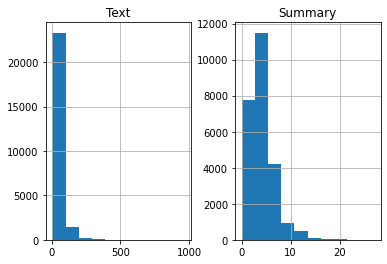

In [10]:
#To get the maximum text and summary length
text_count = []
summaries_count = []

for pt in preprocessed_texts:
    text_count.append(len(pt.split()))
for ps in preprocessed_summaries:
    summaries_count.append(len(ps.split()))

preprocessed_text_summary_df = pd.DataFrame({'Text': text_count, 'Summary': summaries_count})
preprocessed_text_summary_df.hist(bins=10)
plt.show()

In [11]:
reviews_data['preprocessed_texts'] = preprocessed_texts
reviews_data['preprocessed_summaries'] = preprocessed_summaries
#reviews_data['cleaned_summary'].replace('', np.nan, inplace=True)
#reviews_data.dropna(axis=0,inplace=True)

#Attach tokens for parsing the summaries.
reviews_data['preprocessed_summaries'] = reviews_data['preprocessed_summaries'].apply(lambda x : '_starttoken_'+ x + '_endtoken_')

In [12]:
for idx in range(5):
    print("Text and Summary with tokens #",idx+1)
    print(reviews_data.preprocessed_summaries[idx])
    print(reviews_data.preprocessed_texts[idx])
    print('\n')
#Split the dataset into a ratio of 80:20 for training and testing respectively.
x_train, x_label, y_train, y_label = train_test_split(reviews_data['preprocessed_texts'], reviews_data['preprocessed_summaries'], test_size=0.2, random_state=0, shuffle=True) 


Text and Summary with tokens # 1
_starttoken_not as advertised_endtoken_
product arrived labeled jumbo salted peanutsthe peanuts actually small sized unsalted sure error vendor intended represent product jumbo


Text and Summary with tokens # 2
_starttoken_delight says it all_endtoken_
confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story cs lewis lion witch wardrobe treat seduces edmund selling brother sisters witch


Text and Summary with tokens # 3
_starttoken_cough medicine_endtoken_
looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal


Text and Summary with tokens # 4
_starttoken_great taffy_endtoken_
great taffy great price wide assortment yummy taffy delivery quick taffy lover deal


Text and Summary with tokens # 5
_starttoken_nice taffy_endtoken_
got w

In [13]:
#Get the word embeddings using Glove Model.
embedding_idx = dict()
glove_file = open('glove.6B.100d.txt')
for parse_line in glove_file:
    get_values = parse_line.split()
    word = get_values[0]
    co_effs = np.asarray(get_values[1:], dtype='float32')
    embedding_idx[word] = co_effs
glove_file.close()
print('Total number of word vectors loaded %s.' % len(embedding_idx))

#Total percentage of words from x_train available in Word2Vec model.
words_x_train = []
for w_xt in x_train:
    words_x_train.extend(w_xt.split(' '))
print("Total number of words in the train corpus : ", len(words_x_train))

words_x_train = set(words_x_train)
print("Total number of unique words in the train corpus :", len(words_x_train))

x_train_glove_words = set(embedding_idx.keys()).intersection(words_x_train)
print("The total number of words available in both train corpus and glove vectors are {} ({}%) \
 ".format(len(x_train_glove_words), np.round((float(len(x_train_glove_words))/len(words_x_train))*100)))

words_x_train_glove = {}
words_glove = set(embedding_idx.keys())
for w_xt in words_x_train:
    if w_xt in words_glove:
    words_x_train_glove[w_xt] = embedding_idx[w_xt]
print("The Word2Vec length is : ", len(words_x_train_glove))


Total number of word vectors loaded 400000.
Total number of words in the train corpus :  834536
Total number of unique words in the train corpus : 38315
The total number of words available in both train corpus and glove vectors are 21927 (57.0%)  
The Word2Vec length is :  21927


In [14]:
max_text_len = 500
max_summary_len = 20
word_latent_dim = 500
word_embedding_dim = 100

In [15]:
#Process of Tokentization.
x_train_tokenizer = Tokenizer()
x_train_tokenizer.fit_on_texts(list(x_train))
x_train = x_train_tokenizer.texts_to_sequences(x_train)
x_label = x_train_tokenizer.texts_to_sequences(x_label)
x_train = pad_sequences(x_train, maxlen=max_text_len, padding='post') 
x_label = pad_sequences(x_label, maxlen=max_text_len, padding='post')
x_train_size = len(x_train_tokenizer.word_index) +1

#Get the weights of embedding matrix.
word_embedding_matrix = np.zeros((x_train_size, 100))
for word, idx in x_train_tokenizer.word_index.items():
    word_embedding_vector = embedding_idx.get(word)
    if word_embedding_vector is not None:
        word_embedding_matrix[idx] = word_embedding_vector

y_train_tokenizer = Tokenizer()
y_train_tokenizer.fit_on_texts(list(y_train))
y_train = y_train_tokenizer.texts_to_sequences(y_train) 
y_label = y_train_tokenizer.texts_to_sequences(y_label) 
y_train = pad_sequences(y_train, maxlen=max_summary_len, padding='post')
y_label = pad_sequences(y_label, maxlen=max_summary_len, padding='post')
y_train_size = len(y_train_tokenizer.word_index) +1

In [16]:
#Creation of Attention Layer
class AttentionLayer(Layer):
    #Implementation of Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    #Three sets of weights : W_a, U_a, and V_a
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, inp_shape):
        assert isinstance(inp_shape, list)
        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((inp_shape[0][2], inp_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((inp_shape[1][2], inp_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((inp_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)
        super(AttentionLayer, self).build(inp_shape)

    def call(self, inputs, verbose=False):
        #Inputs: [encoder_output_sequence, decoder_output_sequence]
        assert type(inputs) == list
        encoder_output_sequence, decoder_output_sequence = inputs
        if verbose:
            print('encoder_output_sequence>', encoder_output_sequence.shape)
            print('encoder_output_sequence>', encoder_output_sequence.shape)

        def create_energy_step(inputs, states):
            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg
            encoder_sequence_len, encoder_hidden = encoder_output_sequence.shape[1], encoder_output_sequence.shape[2]
            decoder_hidden = inputs.shape[-1]
            reshaped_encoder_outputs = K.reshape(encoder_output_sequence, (-1, encoder_hidden))
            W_a_dot_s = K.reshape(K.dot(reshaped_encoder_outputs, self.W_a), (-1, encoder_sequence_len, encoder_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)
            
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, encoder_hidden)))
            
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)
            encoder_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, encoder_sequence_len))
            encoder_i = K.softmax(encoder_i)

            if verbose:
                print('ei>', encoder_i.shape)
            return encoder_i, [encoder_i]

        def create_context_step(inputs, states):
            context_i = K.sum(encoder_output_sequence * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', context_i.shape)
            return context_i, [context_i]

        def create_inital_state(inputs, hidden_size):
            fake_state_ip = K.zeros_like(inputs)
            fake_state_ip = K.sum(fake_state_ip, axis=[1, 2])
            fake_state_ip = K.expand_dims(fake_state_ip)
            fake_state_ip = K.tile(fake_state_ip, [1, hidden_size])
            return fake_state_ip
        fake_state_ip_c = create_inital_state(encoder_output_sequence, encoder_output_sequence.shape[-1])
        fake_state_ip_e = create_inital_state(encoder_output_sequence, encoder_output_sequence.shape[1])
        last_out, e_outputs, _ = K.rnn(create_energy_step, decoder_output_sequence, [fake_state_ip_e],)
        last_out, c_outputs, _ = K.rnn(create_context_step, e_outputs, [fake_state_ip_c],)

        return c_outputs, e_outputs

    def compute_output_shape(self, inp_shape):
        return [
            tf.TensorShape((inp_shape[1][0], inp_shape[1][1], inp_shape[1][2])),
            tf.TensorShape((inp_shape[1][0], inp_shape[1][1], inp_shape[0][1]))
        ]

In [17]:
#Create the LSTM model.

#Encoder Layers
encoder_inputs = Input(shape=(max_text_len,))
encoder_embedding = Embedding(x_train_size, word_embedding_dim, input_length=max_text_len, \
                              weights=[word_embedding_matrix],trainable=False)(encoder_inputs) 

encoder_LSTM_L1 = LSTM(word_latent_dim, return_sequences=True, return_state=True)
encoder_output_o1, encoder_state_h1, encoder_state_c1 = encoder_LSTM_L1(encoder_embedding)

encoder_LSTM_L2 = LSTM(word_latent_dim, return_sequences=True, return_state=True)
encoder_output_o2, encoder_state_h2, encoder_state_c2 = encoder_LSTM_L2(encoder_output_o1)

encoder_LSTM_L3 = LSTM(word_latent_dim, return_state=True, return_sequences=True)
encoder_output_o3, encoder_state_h3, encoder_state_c3 = encoder_LSTM_L3(encoder_output_o2)

#Decoder Layers
decoder_inputs = Input(shape=(None,))
decoder_embedding_layer = Embedding(y_train_size, word_embedding_dim, trainable=True)
decoder_embedding = decoder_embedding_layer(decoder_inputs)

decoder_LSTM = LSTM(word_latent_dim, return_sequences=True, return_state=True)
decoder_output, decoder_forward_state, decoder_back_state = \
decoder_LSTM(decoder_embedding, initial_state=[encoder_state_h3, encoder_state_c3])

#Attention layer
attention_layer = AttentionLayer(name='attention_layer')
attention_output, attention_states = attention_layer([encoder_output_o3, decoder_output])
decoder_attention_input = Concatenate(axis=-1, name='concat_layer')([decoder_output, attention_output])

#Dense layer
decoder_dense =  TimeDistributed(Dense(y_train_size, activation='softmax'))
decoder_output = decoder_dense(decoder_attention_input)

model = Model([encoder_inputs, decoder_inputs], decoder_output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 100)     3831600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 500, 500), ( 1202000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [18]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
early_stopping = EarlyStopping(monitor='val_loss', mode='min')
model_history = model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:] \
                          , epochs=50, callbacks=[early_stopping], batch_size=128, \
                          validation_data=([x_label, y_label[:,:-1]], y_label.reshape(y_label.shape[0],y_label.shape[1], 1)[:,1:]))

Epoch 1/50
157/157 [==============================] - 294s 2s/step - loss: 1.7543 - val_loss: 1.3838
Epoch 2/50
157/157 [==============================] - 291s 2s/step - loss: 1.4584 - val_loss: 1.3440
Epoch 3/50
157/157 [==============================] - 290s 2s/step - loss: 1.4121 - val_loss: 1.3163
Epoch 4/50
157/157 [==============================] - 290s 2s/step - loss: 1.3708 - val_loss: 1.2824
Epoch 5/50
157/157 [==============================] - 293s 2s/step - loss: 1.3232 - val_loss: 1.2539
Epoch 6/50
157/157 [==============================] - 297s 2s/step - loss: 1.2867 - val_loss: 1.2321
Epoch 7/50
157/157 [==============================] - 301s 2s/step - loss: 1.2390 - val_loss: 1.2081
Epoch 8/50
157/157 [==============================] - 296s 2s/step - loss: 1.2037 - val_loss: 1.1886
Epoch 9/50
157/157 [==============================] - 296s 2s/step - loss: 1.1527 - val_loss: 1.1676
Epoch 10/50
157/157 [==============================] - 298s 2s/step - loss: 1.1084 - val_lo

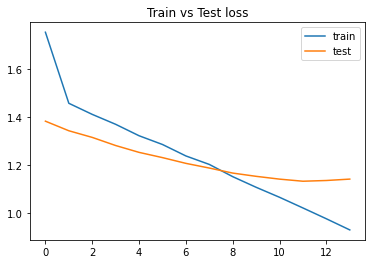

In [19]:
#Plot train vs test loss to check for convergence.
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.title('Train vs Test loss')
plt.legend()
plt.show()

In [20]:
#Creat inference for encoder and decoder layers.
reverse_target_sum_idx = y_train_tokenizer.index_word
reverse_source_txt_idx = x_train_tokenizer.index_word
target_sum_idx = y_train_tokenizer.word_index

#Inference to encoding layers.
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output_o3, encoder_state_h3, encoder_state_c3])

#Inference to decoding layers.
decoder_state_h = Input(shape=(word_latent_dim,))
decoder_state_c = Input(shape=(word_latent_dim,))
decoder_state_inputs = Input(shape=(max_text_len, word_latent_dim))

decoder_embedding_inf = decoder_embedding_layer(decoder_inputs) 
decoder_output_inf, decoder_inf_h, decoder_inf_c = decoder_LSTM(decoder_embedding_inf, initial_state=[decoder_state_h, decoder_state_c])

#Inference to attention and dense layers.
attention_output_inf, attention_states_inf = attention_layer([decoder_state_inputs, decoder_output_inf])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_output_inf, attention_output_inf])
decoder_output_inf = decoder_dense(decoder_inf_concat) 

#Final Model
decoder_model = Model([decoder_inputs] + [decoder_state_inputs, decoder_state_h, decoder_state_c], \
                      [decoder_output_inf] + [decoder_inf_h, decoder_inf_c])

#Prediction of summaries from the lstm model.
def decode_txt_sum(text_sequence):
    encoder_output, encoder_h, encoder_c = encoder_model.predict(text_sequence)
    target_summary = np.zeros((1,1))
    target_summary[0, 0] = target_sum_idx['starttoken']
    stop_process = False
    predicted_summary = ''
    attention_weights_txt_sum = []
    while not stop_process:
        summary_tokens, state_h, state_c = decoder_model.predict([target_summary] + [encoder_output, encoder_h, encoder_c])
        sampled_sum_token_idx = np.argmax(summary_tokens[0, -1, :])
        sampled_sum_token = reverse_target_sum_idx[sampled_sum_token_idx]
        
        if(sampled_sum_token!='endtoken'):
            predicted_summary += ' '+sampled_sum_token
        attention_weights_txt_sum.append((sampled_sum_token_idx, state_h))

        if (sampled_sum_token == 'endtoken' or len(predicted_summary.split()) >= (max_summary_len-1)):
            stop_process = True

        target_summary = np.zeros((1,1))
        target_summary[0, 0] = sampled_sum_token_idx
        encoder_h, encoder_c = state_h, state_c
    return predicted_summary, attention_weights_txt_sum

def sequence2summary(summary_seq):
    new_pred_sum = ''
    for sum in summary_seq:
        if((sum!=0 and sum!=target_sum_idx['starttoken']) and sum!=target_sum_idx['endtoken']):
            new_pred_sum = new_pred_sum + reverse_target_sum_idx[sum]+' '
    return new_pred_sum

def seqence2text(text_seq):
    new_pred_txt = ''
    for txt in text_seq:
        if(txt!=0):
            new_pred_txt = new_pred_txt + reverse_source_txt_idx[txt]+' '
    return new_pred_txt

Input Text:  thrilled dogs got sample new organic dog treats ive fan newmans treats dogs love looking large size treat since last company bought treats discontinued making treats good size rectangle scored break half wish wont breaking half want dogs good sized treat meals keep belly full theyre good crunchy wonderful keeping tarter check smell like earthbr br made organic barley organic lamb organic carrots organic apples organic palm oil organic molasses excellent also cute story back bag paul newmans dog creative amusing im happy found snacks also love option subscribe save amazoncom free shipping 6 bags shipped great deal great product cant wait become available 
Original Summary: organic baked and good sized treats yeah baby 
Predicted Summary:  my dogs love these


Input Text:  great product new brand fallen love products soft one reviewer states replace pill pocket hard stores best place buy 
Original Summary: soft and yummy 
Predicted Summary:  great product


Input Text:  pret

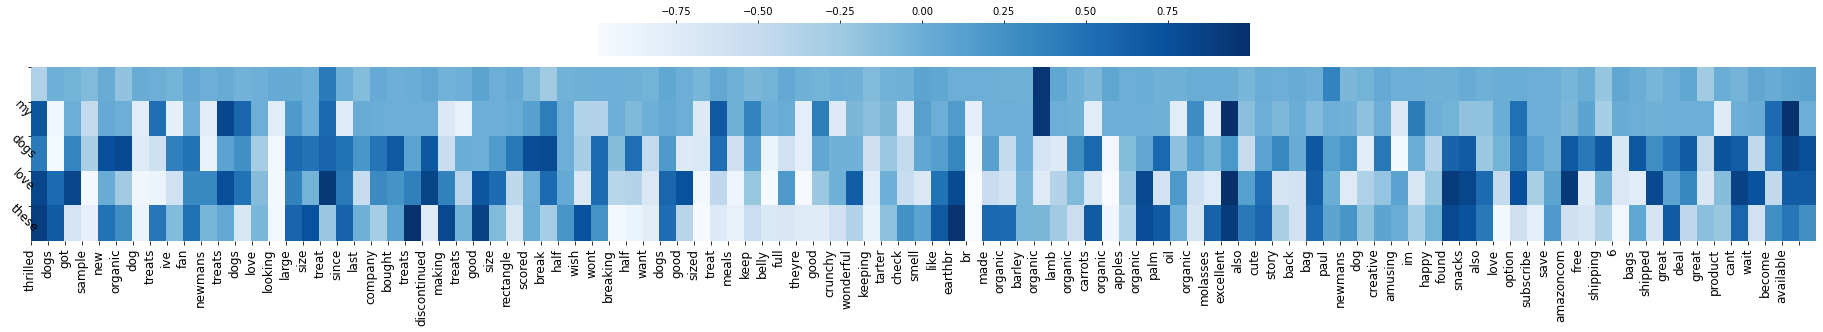

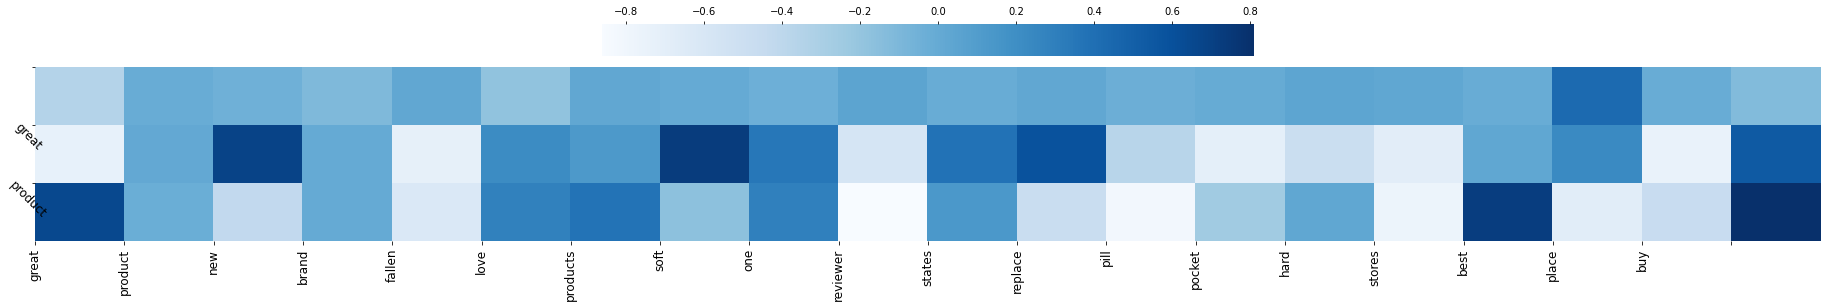

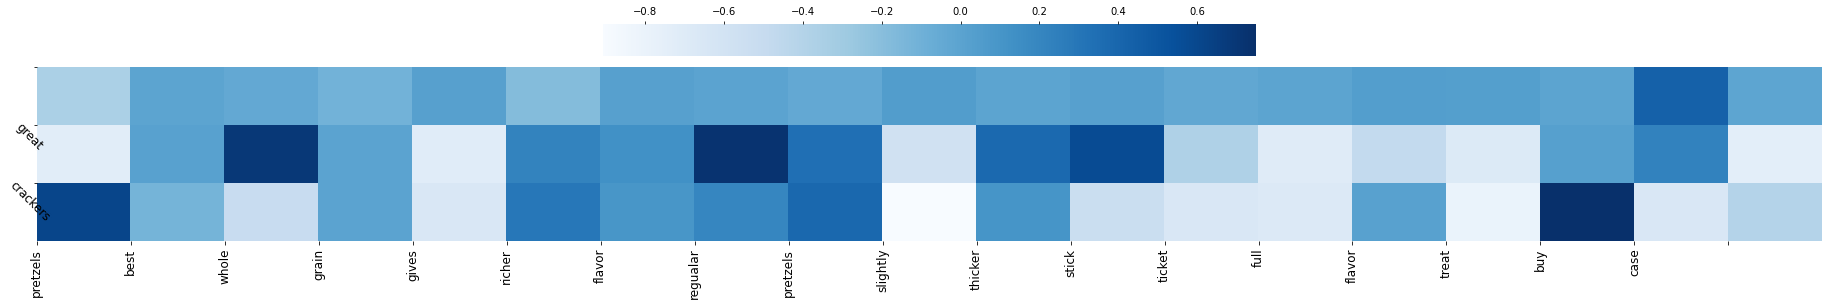

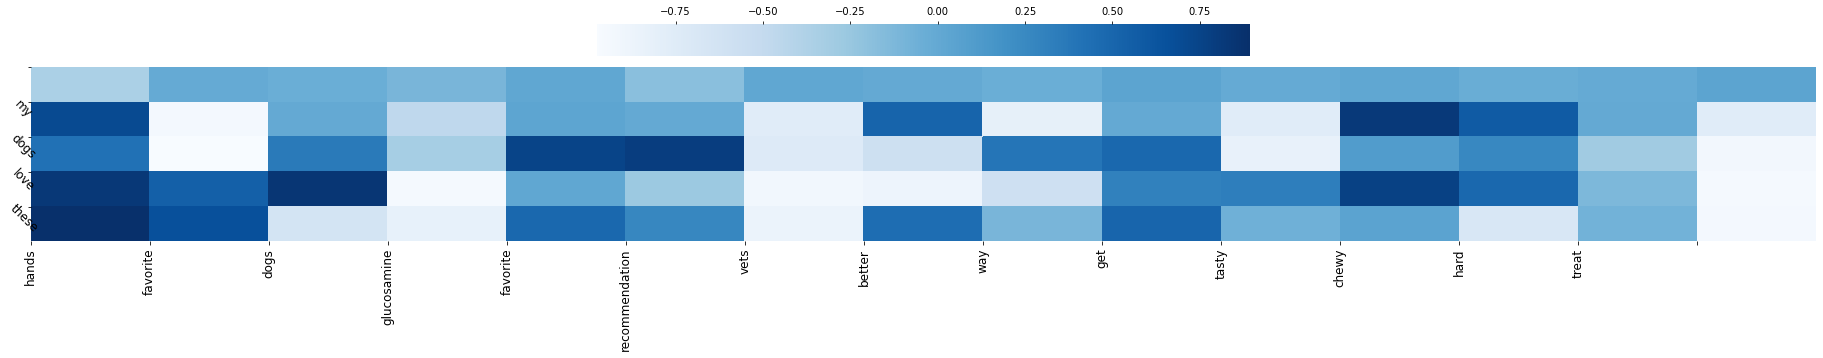

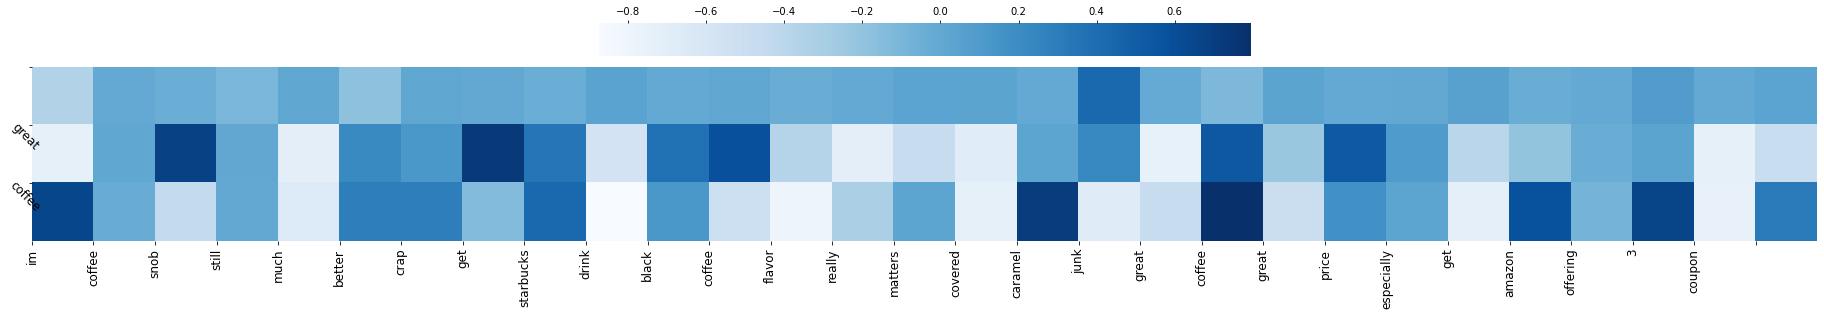

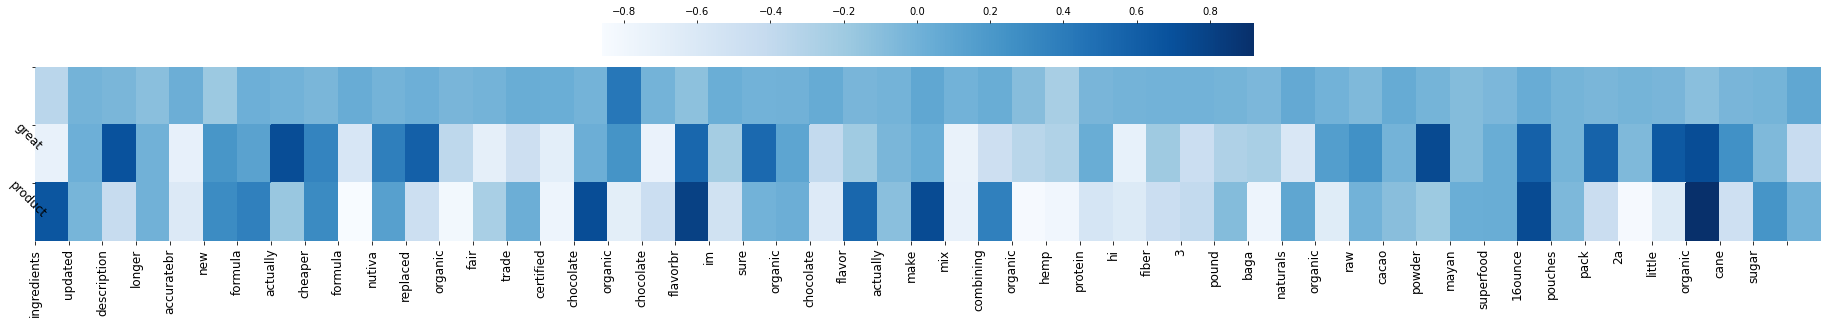

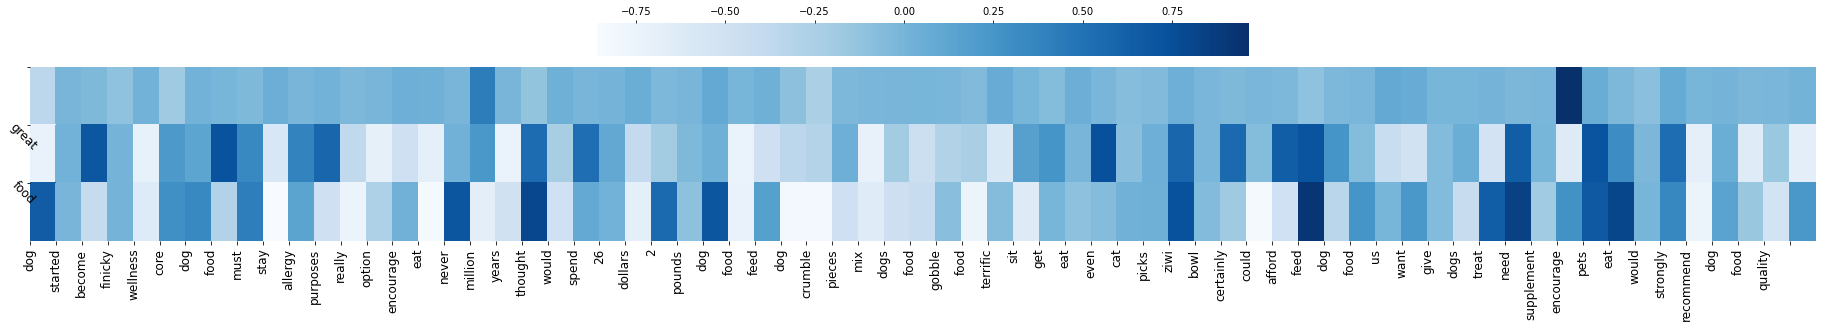

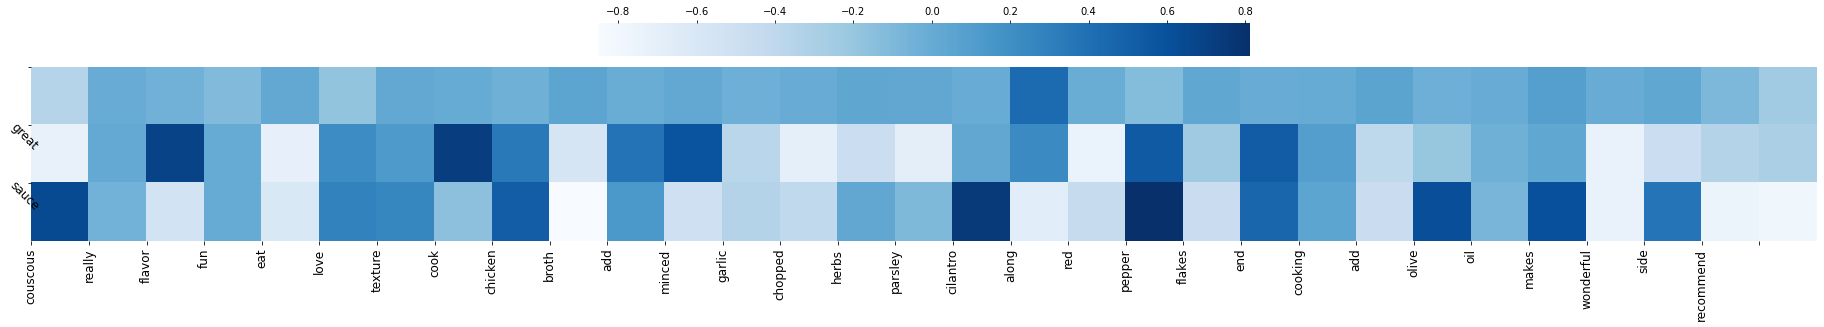

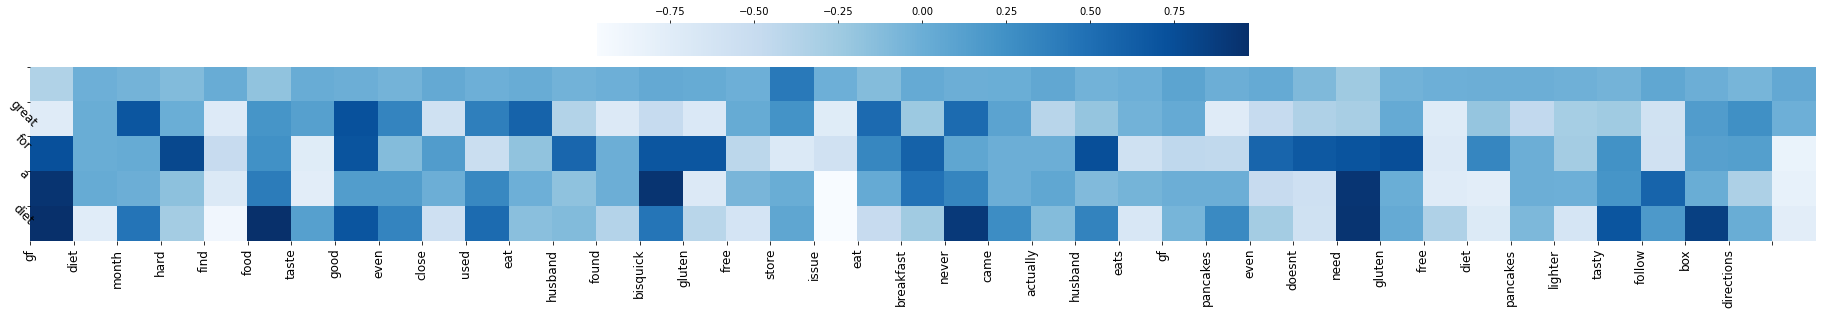

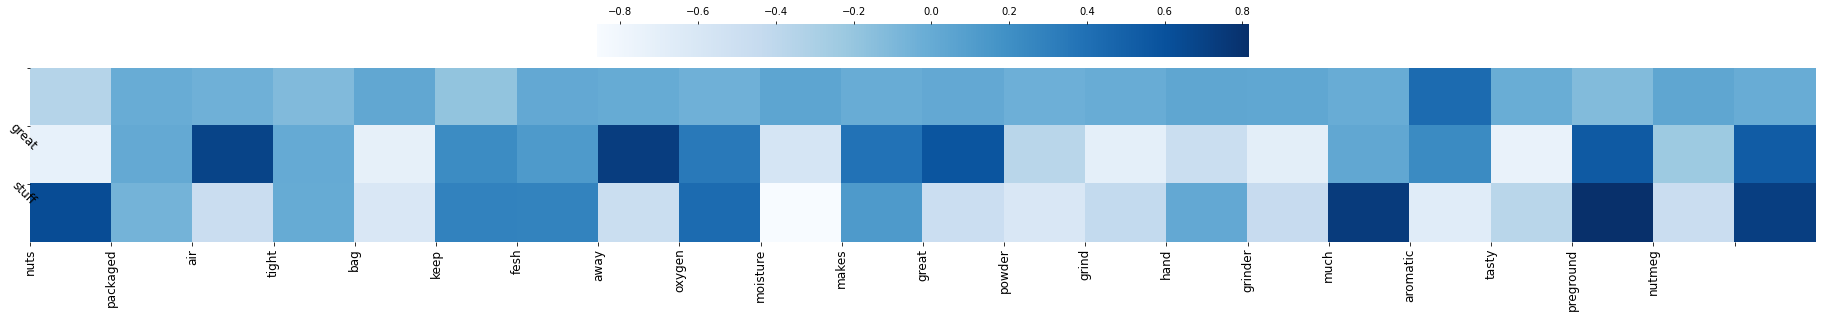

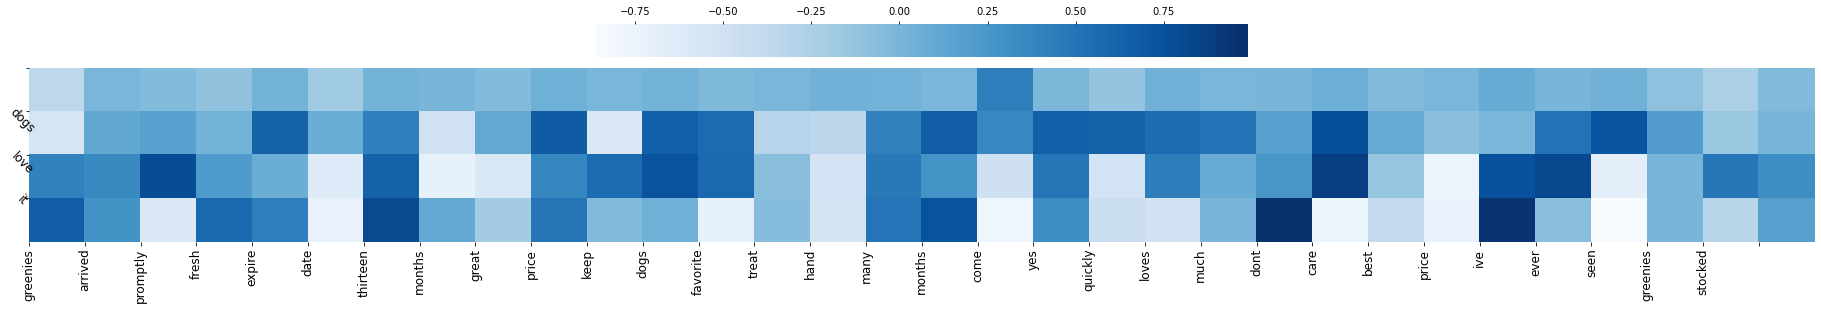

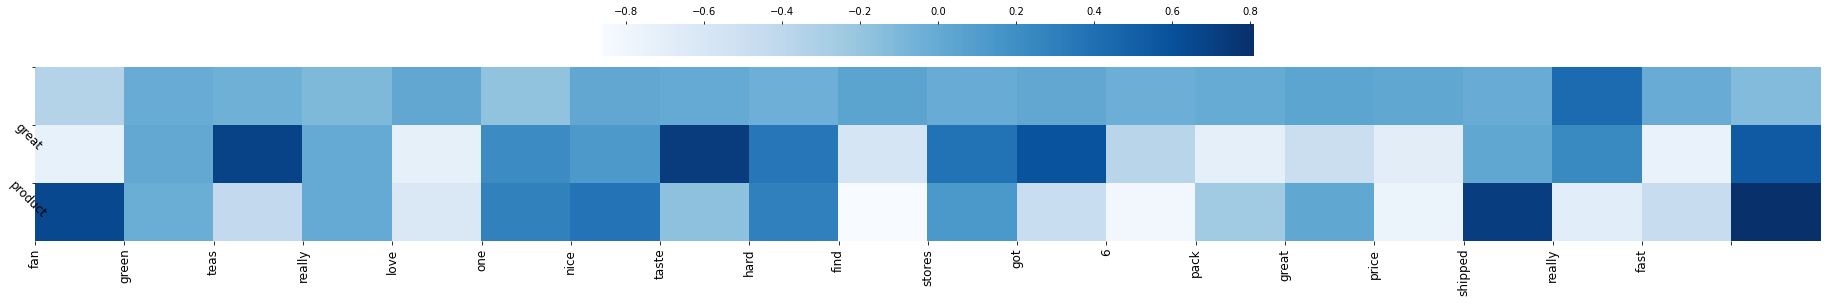

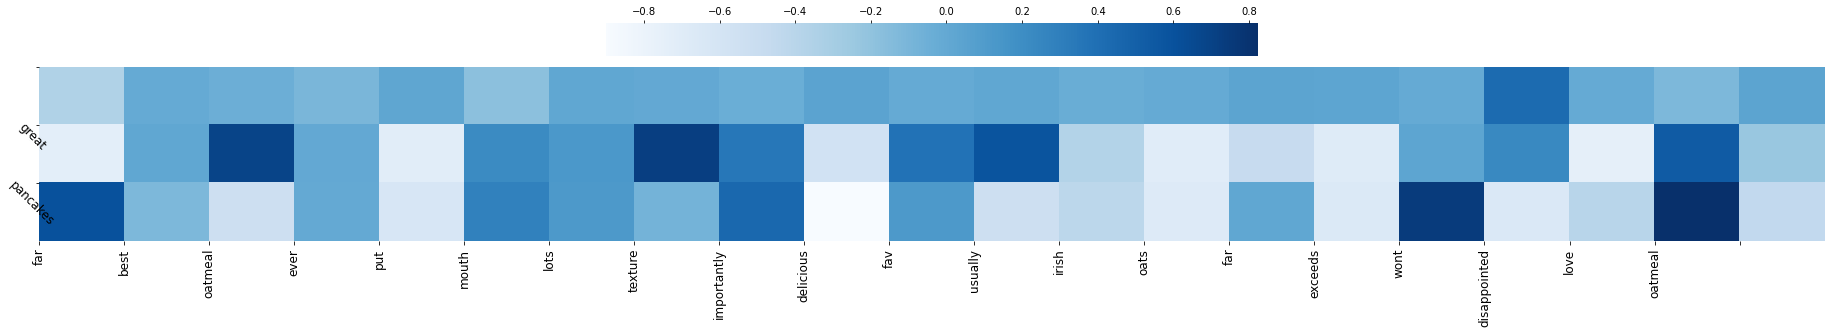

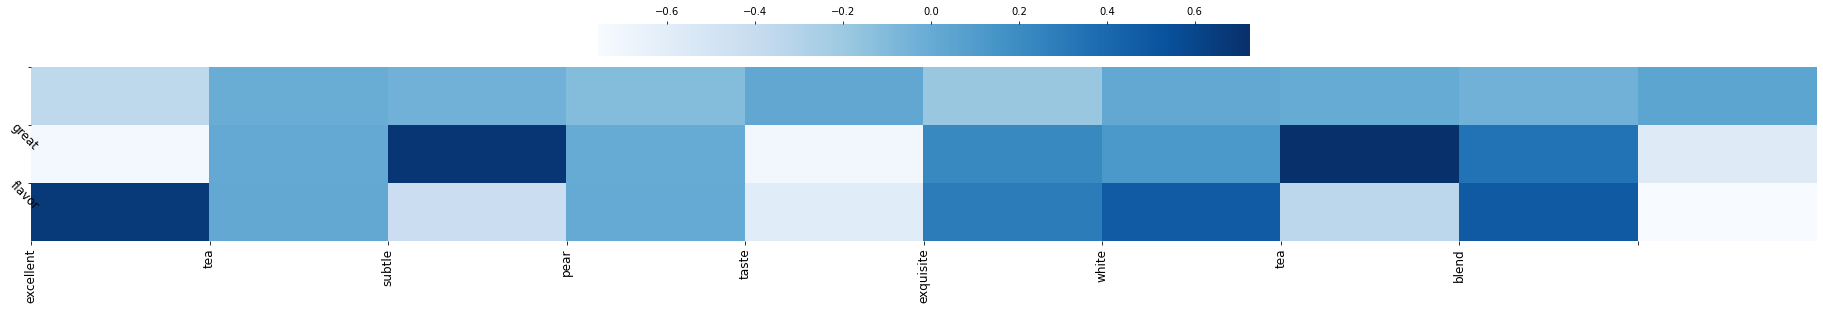

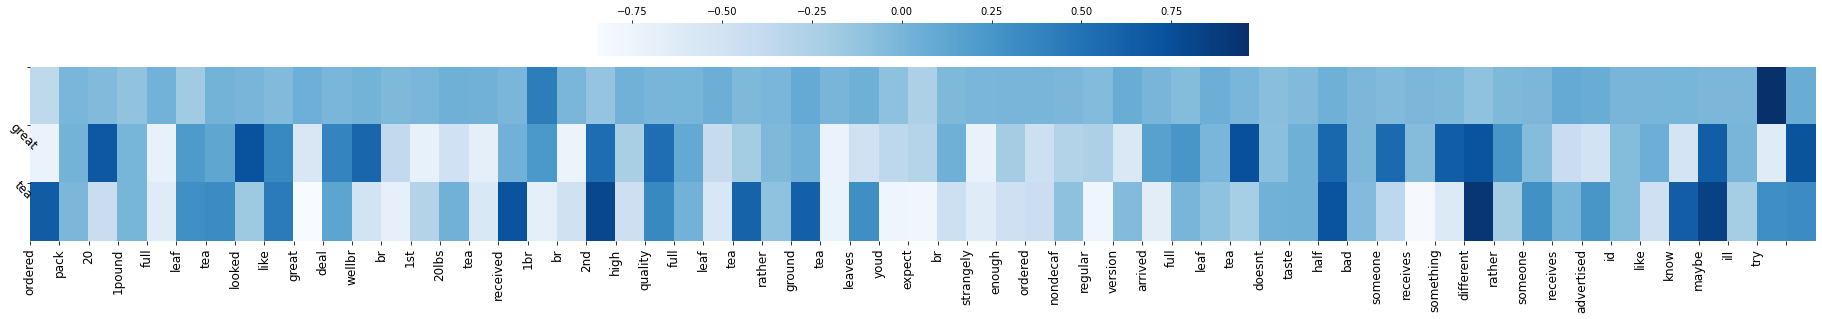

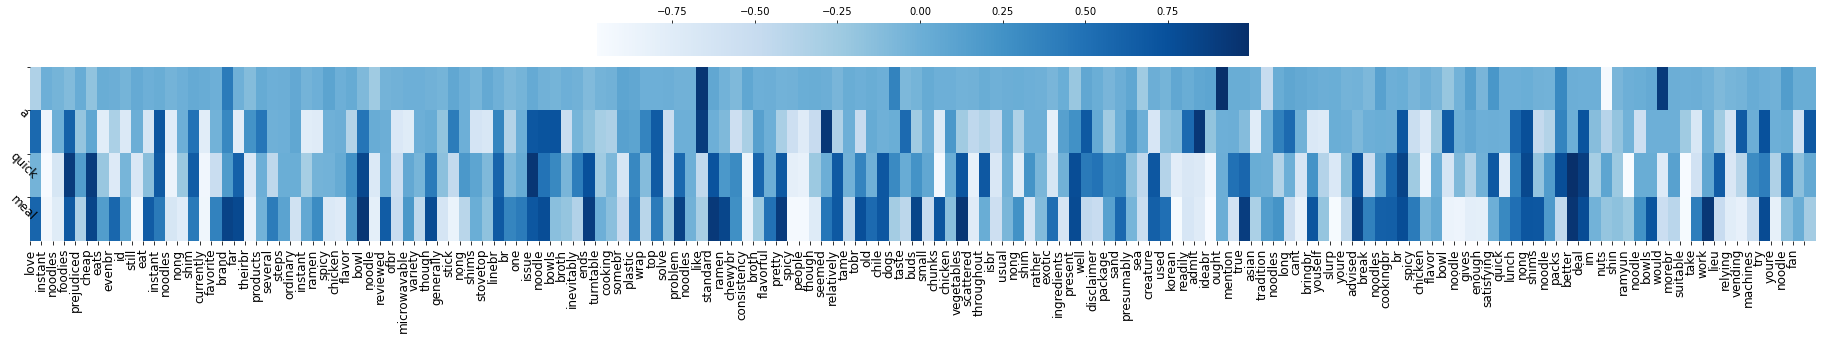

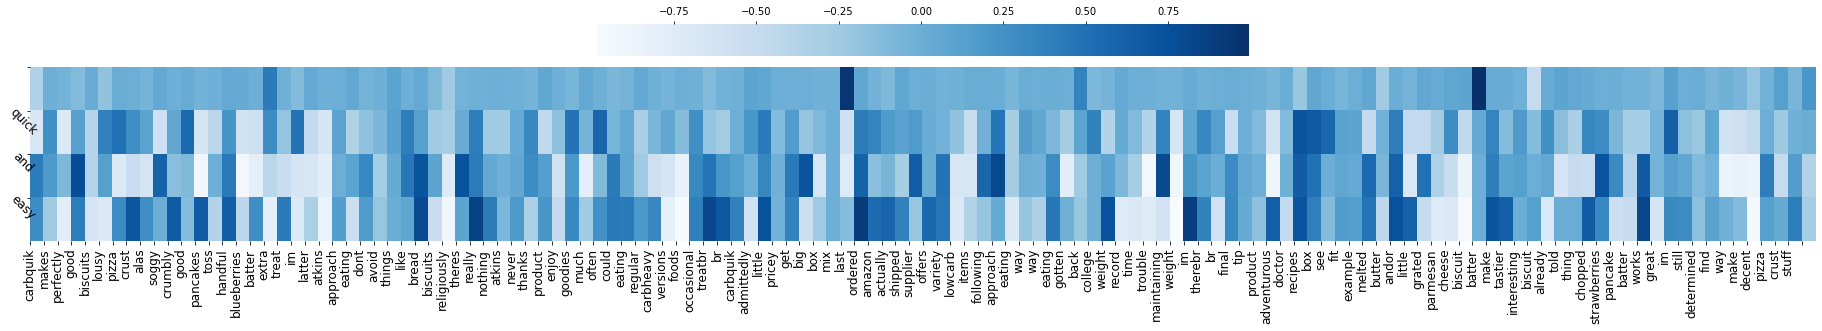

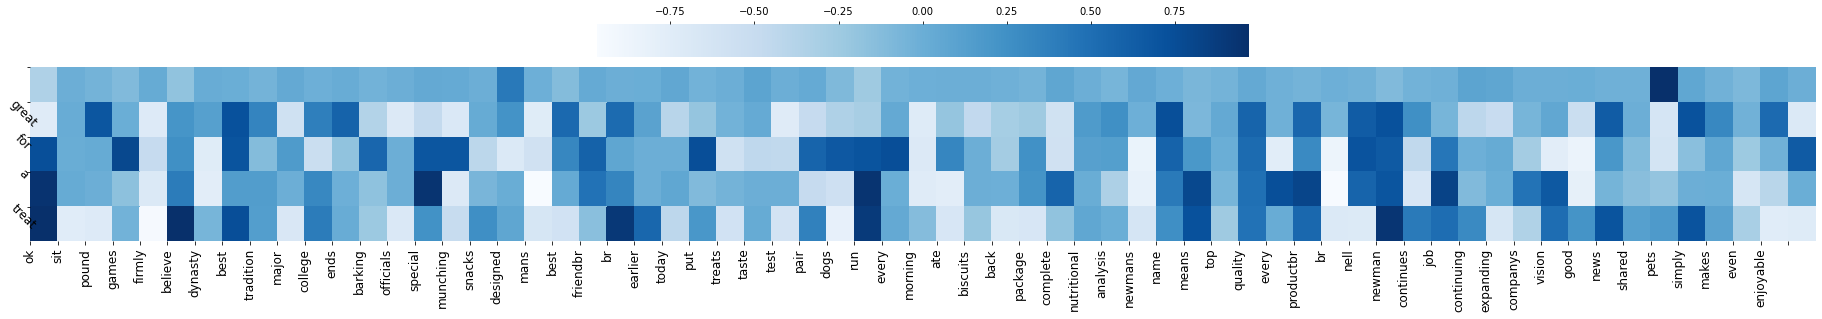

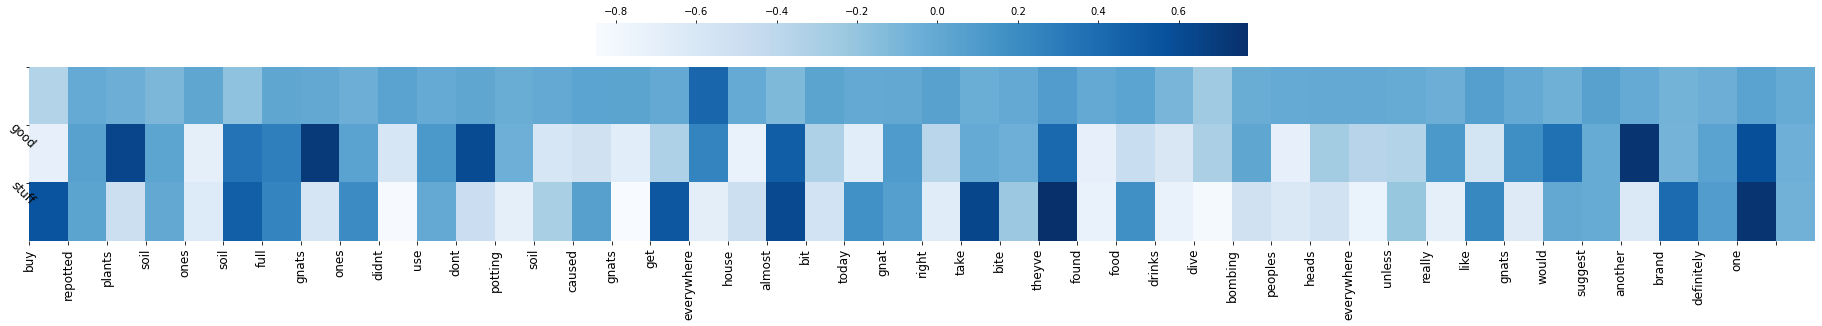

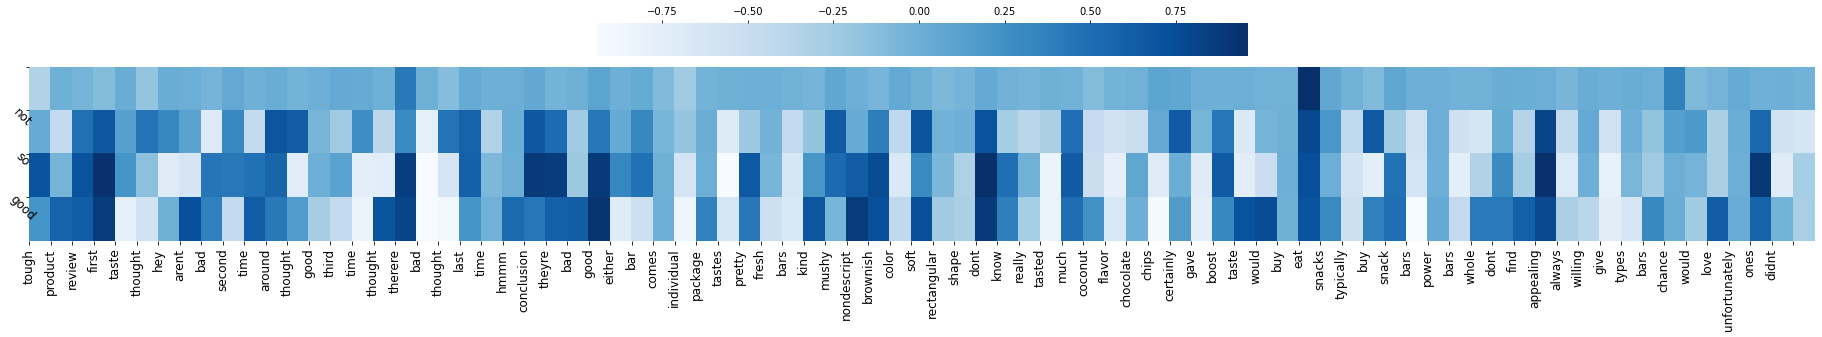

In [21]:
#Visualize Preictions and Attention Plots.
for idx in range(20): #len(x_label)):
    #Results for Task 1
    print("Input Text: ",seqence2text(x_label[idx]))
    print("Original Summary:",sequence2summary(y_label[idx]))
    predicted_sum, attention_weights = decode_txt_sum(x_label[idx].reshape(1,max_text_len))
    print("Predicted Summary:", predicted_sum)
    print("\n")
    
    #print('Attention Plots (To get the importance of each word in input text for the output summary).')
    #Results for Task 2
    attention_matrix_lst = []
    for _, attention in attention_weights:
        attention_matrix_lst.append(attention[0][:len(list(seqence2text(x_label[idx]).split(' ')))])
        attention_matrix = np.array(attention_matrix_lst)

    figure, axis = plt.subplots(figsize=(32, 4))
    sns.heatmap(attention_matrix, cmap=plt.cm.Blues, cbar_kws = dict(use_gridspec=False,location="top")) #annot=True

    axis.set_xticks(np.arange(attention_matrix.shape[1]))
    axis.set_yticks(np.arange(attention_matrix.shape[0]))

    axis.set_xticklabels(seqence2text(x_label[idx]).split(' '), ha='center', minor=False)
    axis.set_yticklabels(predicted_sum.split(' '), ha='center', minor=False)

    axis.tick_params(labelsize=12)
    axis.tick_params(axis='x', labelrotation=90)
    axis.tick_params(axis='y', labelrotation=-45)